# **Synthetic Cybersecurity Dataset Generator with Deep Learning Approaches - VAEs**

This Jupyter notebook demonstrates the generation of synthetic cybersecurity-like datasets
using a Variational Autoencoder (VAE).

**Dataset:** UCI Adult Income Dataset

###**Overview**

- Define generation parameters
- Generate synthetic datasets
- Save outputs for further analysis

###**Goals:**
- Create realistic synthetic data for ML training/testing
- Preserve data utility while enhancing privacy
- Support data augmentation and safe data sharing

### **Key Features:**
- Data preprocessing and normalization
- VAE model training
- Synthetic data generation and export
- Visual loss tracking

### **Install Required Libraries**
Install key Python libraries required for data processing, modeling, and visualization.

In [46]:
!pip install pandas scikit-learn matplotlib seaborn

### **Import Libraries**
Load all necessary Python packages used throughout the notebook.

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import cosine_similarity

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sdmetrics.reports.single_table import QualityReport, DiagnosticReport
from sdmetrics.single_table import KSComplement, DisclosureProtection

### **Load the data**
Load the dataset, check for missing values, and inspect its structure.

In [96]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
columns = [
    "age", "workclass", "fnlwgt", "education", "education-num",
    "marital-status", "occupation", "relationship", "race",
    "sex", "capital-gain", "capital-loss", "hours-per-week",
    "native-country", "income"
]
df = pd.read_csv(url, names=columns, na_values=" ?", skipinitialspace=True)

In [97]:
df.head(10)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
5,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
6,49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,<=50K
7,52,Self-emp-not-inc,209642,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,>50K
8,31,Private,45781,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,>50K
9,42,Private,159449,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States,>50K


In [98]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [99]:
df.shape

(32561, 15)

In [100]:
print(df.isna().sum())

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64


In [101]:
df.dropna(inplace=True)

### **Encode Categorical Variables**
Convert all categorical columns into numeric format using Label Encoding.

In [102]:
categorical_cols = df.select_dtypes(include='object').columns
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [103]:
display(df.head(10))

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,7,77516,9,13,4,1,1,4,1,2174,0,40,39,0
1,50,6,83311,9,13,2,4,0,4,1,0,0,13,39,0
2,38,4,215646,11,9,0,6,1,4,1,0,0,40,39,0
3,53,4,234721,1,7,2,6,0,2,1,0,0,40,39,0
4,28,4,338409,9,13,2,10,5,2,0,0,0,40,5,0
5,37,4,284582,12,14,2,4,5,4,0,0,0,40,39,0
6,49,4,160187,6,5,3,8,1,2,0,0,0,16,23,0
7,52,6,209642,11,9,2,4,0,4,1,0,0,45,39,1
8,31,4,45781,12,14,4,10,1,4,0,14084,0,50,39,1
9,42,4,159449,9,13,2,4,0,4,1,5178,0,40,39,1


### **Normalize Features for VAE**
Scales all features to the [0, 1] range for better neural network performance.


In [104]:
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
print(df_scaled.describe())

                age     workclass        fnlwgt     education  education-num  \
count  32561.000000  32561.000000  32561.000000  32561.000000   32561.000000   
mean       0.295639      0.483612      0.120545      0.686547       0.605379   
std        0.186855      0.181995      0.071685      0.258018       0.171515   
min        0.000000      0.000000      0.000000      0.000000       0.000000   
25%        0.150685      0.500000      0.071679      0.600000       0.533333   
50%        0.273973      0.500000      0.112788      0.733333       0.600000   
75%        0.424658      0.500000      0.152651      0.800000       0.733333   
max        1.000000      1.000000      1.000000      1.000000       1.000000   

       marital-status    occupation  relationship          race           sex  \
count    32561.000000  32561.000000  32561.000000  32561.000000  32561.000000   
mean         0.435306      0.469481      0.289272      0.916464      0.669205   
std          0.251037      0.302061 

In [105]:
train_data, test_data = train_test_split(df_scaled, test_size=0.2, random_state=42)

### **Variational Autoencoder (VAE)**
Implement VAE model with encoder, decoder, and reparameterization logic.

In [117]:
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim=10):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(nn.Linear(input_dim, 64), nn.ReLU(), nn.Linear(64, 32), nn.ReLU())
        self.fc_mu = nn.Linear(32, latent_dim)
        self.fc_logvar = nn.Linear(32, latent_dim)
        self.decoder = nn.Sequential(nn.Linear(latent_dim, 32), nn.ReLU(), nn.Linear(32, 64), nn.ReLU(), nn.Linear(64, input_dim), nn.Sigmoid())

    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        return mu + std * torch.randn_like(std)

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

### **VAE Loss Function**

In [118]:
def vae_loss(recon_x, x, mu, logvar):
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='mean')
    kl_div = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_div

### **Prepare DataLoader and Train the VAE**
Train the VAE model using batches of normalized input data.

In [119]:
input_dim = df_scaled.shape[1]
model = VAE(input_dim)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
X = torch.tensor(df_scaled.values, dtype=torch.float32)
loader = DataLoader(X, batch_size=256, shuffle=True)

In [121]:
epochs = 20
losses = []

In [122]:
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(batch)
        loss = vae_loss(recon_batch, batch, mu, logvar)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    losses.append(avg_loss)
    print(f"Epoch {epoch + 1}, Loss: {avg_loss:.4f}")



Epoch 1, Loss: 0.1486
Epoch 2, Loss: 0.1128
Epoch 3, Loss: 0.0838
Epoch 4, Loss: 0.0706
Epoch 5, Loss: 0.0663
Epoch 6, Loss: 0.0649
Epoch 7, Loss: 0.0643
Epoch 8, Loss: 0.0639
Epoch 9, Loss: 0.0638
Epoch 10, Loss: 0.0637
Epoch 11, Loss: 0.0636
Epoch 12, Loss: 0.0635
Epoch 13, Loss: 0.0635
Epoch 14, Loss: 0.0634
Epoch 15, Loss: 0.0634
Epoch 16, Loss: 0.0634
Epoch 17, Loss: 0.0633
Epoch 18, Loss: 0.0633
Epoch 19, Loss: 0.0633
Epoch 20, Loss: 0.0633


### **Generate Synthetic Data Using Trained VAE**
Sample from the latent space and decodes it into synthetic data.

In [123]:
model.eval()
with torch.no_grad():
    z = torch.randn(len(df_scaled), 10)
    synthetic_data = model.decode(z).numpy()

In [124]:
synthetic_df = pd.DataFrame(scaler.inverse_transform(synthetic_data), columns=df.columns)

In [125]:
for col in categorical_cols:
    synthetic_df[col] = synthetic_df[col].round().astype(int)
    synthetic_df[col] = label_encoders[col].inverse_transform(synthetic_df[col].clip(
        0, len(label_encoders[col].classes_) - 1))

### **Save the output**

In [132]:
synthetic_df.to_csv("synthetic_data_vae.csv", index=False)
print("Synthetic data saved as 'synthetic_data_vae.csv'")
synthetic_df.head(10)

Synthetic data saved as 'synthetic_data_vae.csv'


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,40.139137,Private,215621.625000,Doctorate,9.947360,Married-spouse-absent,Machine-op-inspct,Other-relative,White,Male,3822.501221,161.176620,40.905090,Taiwan,<=50K
1,40.790428,Private,248214.406250,Doctorate,9.802199,Married-spouse-absent,Machine-op-inspct,Other-relative,White,Male,3298.380859,172.761978,42.155640,South,<=50K
2,40.316212,Private,186544.093750,Doctorate,9.925671,Married-spouse-absent,Machine-op-inspct,Not-in-family,White,Male,2177.384277,102.254456,41.804756,Thailand,<=50K
3,40.339649,Private,220836.484375,Doctorate,9.894745,Married-spouse-absent,Machine-op-inspct,Other-relative,White,Male,2274.518799,115.877487,40.393230,Thailand,<=50K
4,41.618530,Private,251435.984375,Doctorate,9.906609,Married-spouse-absent,Machine-op-inspct,Other-relative,White,Male,2765.990967,200.733582,42.356438,Taiwan,<=50K
5,38.086830,Private,152506.187500,Doctorate,10.141512,Married-spouse-absent,Machine-op-inspct,Not-in-family,White,Male,680.355713,37.338787,37.910343,United-States,<=50K
6,38.271477,Private,146677.875000,Doctorate,10.092121,Married-spouse-absent,Machine-op-inspct,Not-in-family,White,Male,1385.115356,52.341461,37.777306,Thailand,<=50K
7,41.054337,Private,250614.734375,Doctorate,9.812742,Married-spouse-absent,Machine-op-inspct,Other-relative,White,Male,3434.553223,163.937683,41.330009,South,<=50K
8,40.859760,Private,237411.718750,Doctorate,9.939766,Married-spouse-absent,Machine-op-inspct,Other-relative,White,Male,3576.851318,170.525330,42.291504,South,<=50K
9,36.225761,Private,102088.968750,HS-grad,10.445268,Married-spouse-absent,Machine-op-inspct,Not-in-family,White,Male,258.594788,15.911986,36.161926,United-States,<=50K


### **Visualize Training Loss**
Plot the VAE training loss over epochs to monitor learning progress.

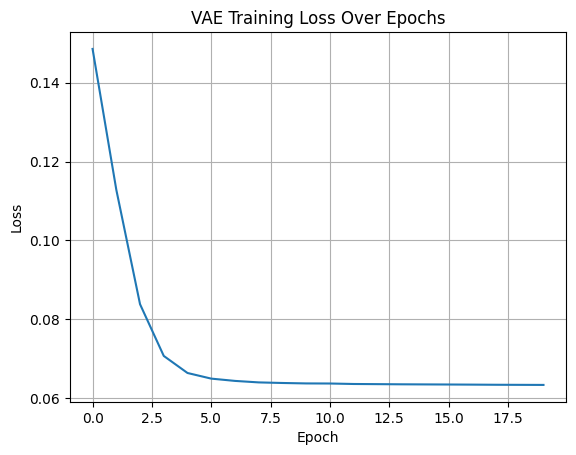

In [133]:
plt.plot(losses)
plt.title("VAE Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.show()

### **Evaluation**

In [72]:
!pip install sdmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.4/193.4 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 3.7 MB/s eta 0:00:00


In [134]:
from sdmetrics.reports.single_table import QualityReport, DiagnosticReport
from sdmetrics.single_table import KSComplement, DisclosureProtection

# Metadata
metadata_dict = {
    "columns": {
        col: {"sdtype": "categorical" if col in categorical_cols else "numerical"}
        for col in df.columns
    }
}

df_proc = df.copy()

# Quality Report
report = QualityReport()
report.generate(real_data=df_proc, synthetic_data=synthetic_df, metadata=metadata_dict)
print(f"Overall Quality Score: {report.get_score():.2f}")
report.get_visualization(property_name='Column Shapes')


Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 15/15 [00:00<00:00, 103.51it/s]|
Column Shapes Score: 18.18%

(2/2) Evaluating Column Pair Trends: |██████████| 105/105 [00:01<00:00, 69.09it/s]|
Column Pair Trends Score: 8.59%

Overall Score (Average): 13.38%

Overall Quality Score: 0.13


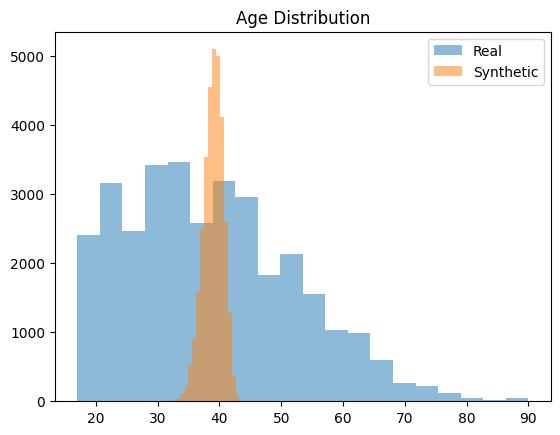

In [135]:
plt.hist(df_proc["age"], alpha=0.5, label="Real", bins=20)
plt.hist(synthetic_df["age"], alpha=0.5, label="Synthetic", bins=20)
plt.title("Age Distribution")
plt.legend()
plt.show()

### **k-Anonymity and l-Diversity**

In [83]:
qi_cols = ["age", "education", "race", "sex"]
k_anon = df_proc[qi_cols].value_counts().min()
print(f"Estimated k-Anonymity: {k_anon}")
l_div = df_proc.groupby(qi_cols)["income"].nunique().min()
print(f"Estimated l-Diversity: {l_div}")

Estimated k-Anonymity: 1
Estimated l-Diversity: 1


### **Cosine similarity**

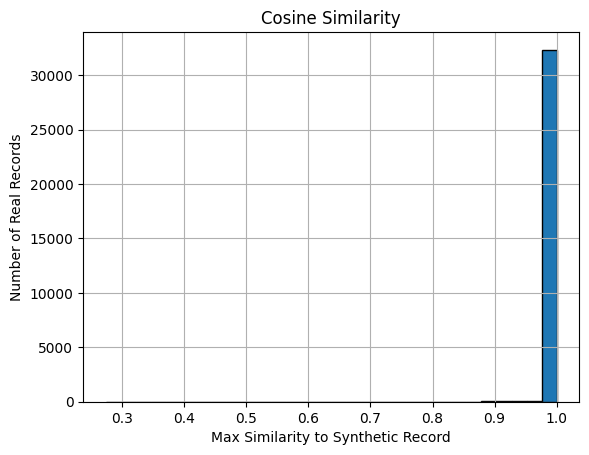

Mean of max cosine similarity: 0.999


In [138]:
real_numeric = df.select_dtypes(include='number')
synth_numeric = synthetic_df.select_dtypes(include='number')

common_columns = list(set(real_numeric.columns) & set(synth_numeric.columns))
real_aligned = real_numeric[common_columns]
synth_aligned = synth_numeric[common_columns]

cos_sim = cosine_similarity(real_aligned, synth_aligned)
max_sim = cos_sim.max(axis=1)

plt.hist(max_sim, bins=30, edgecolor='black')
plt.title("Cosine Similarity")
plt.xlabel("Max Similarity to Synthetic Record")
plt.ylabel("Number of Real Records")
plt.grid(True)
plt.show()

print(f"Mean of max cosine similarity: {max_sim.mean():.3f}")


In [140]:
from sdmetrics.single_table import DisclosureProtectionEstimate

risk_score = DisclosureProtectionEstimate.compute(
    df_proc, synthetic_df,
    known_column_names=['age', 'sex'],
    sensitive_column_names=['income']
)
print(f"Estimated Disclosure Risk Score: {risk_score:.2f}")

Estimating Disclosure Protection (Score=nan): 100%|██████████| 10/10 [00:18<00:00,  1.86s/it]

Estimated Disclosure Risk Score: nan


### **Duplicate rows**

In [147]:
for col in df_proc.select_dtypes(include=['float64', 'int64']).columns:
    synthetic_df[col] = synthetic_df[col].astype(df_proc[col].dtype)

duplicates = synthetic_df.merge(df_proc, how='inner')
print(f"Exact duplicates: {len(duplicates)} rows")

Exact duplicates: 0 rows


### **Model Accuracy on Real Data**

In [148]:
X_real = df_proc.drop("income", axis=1)
y_real = df_proc["income"]
X_synth = synthetic_df.drop("income", axis=1)
y_synth = synthetic_df["income"]
clf = RandomForestClassifier()
clf.fit(X_synth, y_synth)
acc = accuracy_score(y_real, clf.predict(X_real))
print(f"Model Accuracy on Real Data: {acc:.2f}")

Model Accuracy on Real Data: 0.76


In [149]:
# Diagnostic report
diag = DiagnosticReport()
diag.generate(df_proc, synthetic_df, metadata=metadata_dict)
print(diag.get_properties())

Generating report ...

(1/2) Evaluating Data Validity: |██████████| 15/15 [00:00<00:00, 265.20it/s]|
Data Validity Score: 73.33%

(2/2) Evaluating Data Structure: |██████████| 1/1 [00:00<00:00, 180.78it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 86.67%

         Property     Score
0   Data Validity  0.733333
1  Data Structure  1.000000


### **PCA visualization**

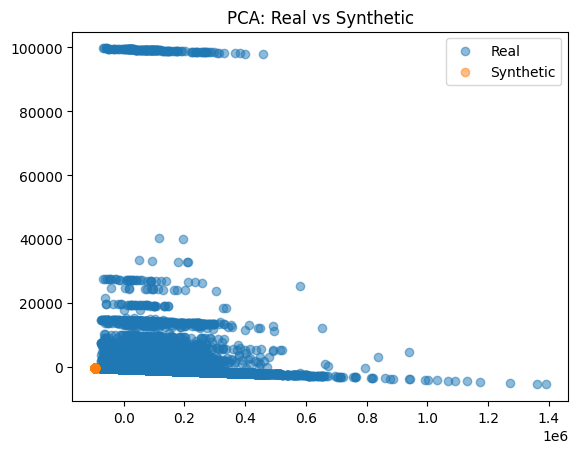

In [150]:
combined = pd.concat([df_proc, synthetic_df])
labels = ["Real"] * len(df_proc) + ["Synthetic"] * len(synthetic_df)
pca = PCA(n_components=2)
pca_vals = pca.fit_transform(combined.select_dtypes(include=np.number))
plt.scatter(pca_vals[:len(df_proc), 0], pca_vals[:len(df_proc), 1], label="Real", alpha=0.5)
plt.scatter(pca_vals[len(df_proc):, 0], pca_vals[len(df_proc):, 1], label="Synthetic", alpha=0.5)
plt.legend()
plt.title("PCA: Real vs Synthetic")
plt.show()

### **Limitations**

- VAE assumes a continuous latent space and may not preserve complex categorical relationships
- Quality of synthetic data depends on input data quality and preprocessing
- High-cardinality categorical columns might suffer from mode collapse

### **Conclusion**

This notebook demonstrates a full pipeline for generating and evaluating synthetic data using Variational Autoencoders. The approach balances data utility and privacy, making it useful for safe data sharing and augmentation.